##### Copyright 2018 The TensorFlow Constrained Optimization Authors. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

> http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Overview

This notebook will show one of the challenges that arises in practice when training machine learning models to satisfy constraints such as fairness constraints: namely the difficulty that arises with non-convex models. Typical approaches to enforce such constraints are based on the classical method of the Lagrangian multipliers. It is well known that in the convex setting, under fairly general conditions, a saddle point to the Lagrangian will correspond to an optimal and feasible solution to the original constrained optimization problem. However, such no longer holds in the non-convex setting: a saddle point no longer necessarily corresponds to a desired solution to the constrained optimization problem. Even worse, there may not even be a stationary point to converge to in the non-convex setting thus causing gradient-based methods like SGD to possibly not converge and thus oscillate.


We show that this problem appears with the [[ProPublica COMPAS dataset]](https://github.com/propublica/compas-analysis) when we train a simple neural network as the underlying model to predict 2-year recividism with equal opportunity constraints based on race and gender. This motivates why stochastic classifiers are necessary, as proposed in [[CoJiSr19]](https://arxiv.org/abs/1804.06500). In particular, there are four equal opportunity constraints: one for each of the 4 protected groups (White, Black, Female, Male). As a reminder, equal opportunity enforces that the true positive rate of our classifier on each protected group matches the true positive rate of our classifer on the overall dataset.


### Importing required libraries.

In [1]:
import math
import random
import numpy as np
import pandas as pd
import warnings
from six.moves import xrange
import tensorflow.compat.v1 as tf
import tensorflow_constrained_optimization as tfco
import matplotlib.pyplot as plt

tf.disable_eager_execution()

warnings.filterwarnings('ignore')
%matplotlib inline

### Reading and processing dataset.

We load and download the dataset and do some pre-processing. We remove some of the datapoints for which some of the features are missing and then perform some feature transformation, including changing categorical features into binary features and bucketizing some of the continuous features.

In [2]:
LABEL_COLUMN = 'two_year_recid'
PROTECTED_COLUMNS = ['sex_Female', 'sex_Male', 'race_Caucasian', 'race_African-American']

def get_data():
    data_path = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
    df = pd.read_csv(data_path)
    FEATURES = [
      'age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex',
      'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid',
      'two_year_recid']
    df = df[FEATURES]
    df = df[df.days_b_screening_arrest <= 30]
    df = df[df.days_b_screening_arrest >= -30]
    df = df[df.is_recid != -1]
    df = df[df.c_charge_degree != 'O']
    df = df[df.score_text != 'N/A']
    continuous_features = [
      'priors_count', 'days_b_screening_arrest', 'is_recid', 'two_year_recid'
    ]
    continuous_to_categorical_features = ['age', 'decile_score', 'priors_count']
    categorical_features = ['c_charge_degree', 'race', 'score_text', 'sex']

    def binarize_categorical_columns(input_df, categorical_columns=[]):
        binarized_df = pd.get_dummies(input_df, columns=categorical_columns)
        return binarized_df
    
    def bucketize_continuous_column(input_df, continuous_column_name, bins=None):
        input_df[continuous_column_name] = pd.cut(
            input_df[continuous_column_name], bins, labels=False)

    for c in continuous_to_categorical_features:
        b = [0] + list(np.percentile(df[c], [20, 40, 60, 80, 90, 100]))
        if c == 'priors_count':
            b = list(np.percentile(df[c], [0, 50, 70, 80, 90, 100]))
        bucketize_continuous_column(df, c, bins=b)

    df = binarize_categorical_columns(
        df,
        categorical_columns=categorical_features + continuous_to_categorical_features)

    to_fill = [
      u'decile_score_0', u'decile_score_1', u'decile_score_2',
      u'decile_score_3', u'decile_score_4', u'decile_score_5'
    ]
    for i in range(len(to_fill) - 1):
        df[to_fill[i]] = df[to_fill[i:]].max(axis=1)
    to_fill = [
      u'priors_count_0.0', u'priors_count_1.0', u'priors_count_2.0',
      u'priors_count_3.0', u'priors_count_4.0'
    ]
    for i in range(len(to_fill) - 1):
        df[to_fill[i]] = df[to_fill[i:]].max(axis=1)

    features = [
      u'days_b_screening_arrest', u'c_charge_degree_F', u'c_charge_degree_M',
      u'race_African-American', u'race_Asian', u'race_Caucasian',
      u'race_Hispanic', u'race_Native American', u'race_Other',
      u'score_text_High', u'score_text_Low', u'score_text_Medium',
      u'sex_Female', u'sex_Male', u'age_0', u'age_1', u'age_2', u'age_3',
      u'age_4', u'age_5', u'decile_score_0', u'decile_score_1',
      u'decile_score_2', u'decile_score_3', u'decile_score_4',
      u'decile_score_5', u'priors_count_0.0', u'priors_count_1.0',
      u'priors_count_2.0', u'priors_count_3.0', u'priors_count_4.0'
    ]
    df = df[features + [LABEL_COLUMN]]
    return df, features

We now load the data and make a random train/test split.

In [3]:
df, FEATURE_NAMES = get_data()

tf.set_random_seed(1234)

df.sample(frac=1, random_state=12345)
N = len(df)
train_df = df[:int(N * 0.7)]
test_df = df[int(N * 0.7):]

### Model.

We use a 1-hidden layer Neural Network with ReLU activations and 10 hidden units. We show that even with a small neural network, we will already see some oscillation and non-convergence that arises due to non-convexity.

In the following code, we initialize the placeholders and model. In build_train_op, we set up the constrained optimization problem. We create a rate context for the entire dataset, and compute the overall true positive rate as the positive prediction rate on the positively labeled subset. We then construct a constraint for each of the protected groups based on the difference between the true positive rates of the protected group and that of the overall dataset. We then construct a minimization problem using RateMinimizationProblem and use the ProxyLagrangianOptimizerV1 as the solver. build_train_op initializes a training operation which will later be used to actually train the model. 


In [4]:
def _construct_model(input_tensor, hidden_units=10):
    hidden = tf.layers.dense(
        inputs=input_tensor,
        units=hidden_units,
        activation=tf.nn.relu)
    output = tf.layers.dense(
        inputs=hidden,
        units=1,
        activation=None)
    return output

class Model(object):
    def __init__(self,
                 feature_names,
                 hidden_units=10,
                 tpr_max_diff=0):
        tf.random.set_random_seed(123)
        self.feature_names = feature_names
        self.tpr_max_diff = tpr_max_diff
        num_features = len(self.feature_names)
        self.features_placeholder = tf.placeholder(
            tf.float32, shape=(None, num_features), name='features_placeholder')
        self.labels_placeholder = tf.placeholder(
            tf.float32, shape=(None, 1), name='labels_placeholder')
        self.protected_placeholders = [tf.placeholder(tf.float32, shape=(None, 1), name=attribute+"_placeholder") for attribute in PROTECTED_COLUMNS]
        self.predictions_tensor = _construct_model(
            self.features_placeholder, hidden_units=hidden_units)

    def build_train_op(self,
                       learning_rate,
                       unconstrained=False):
        ctx = tfco.rate_context(self.predictions_tensor, self.labels_placeholder)
        positive_slice = ctx.subset(self.labels_placeholder > 0) 
        overall_tpr = tfco.positive_prediction_rate(positive_slice)
        constraints = []
        if not unconstrained:
            for placeholder in self.protected_placeholders:
                slice_tpr = tfco.positive_prediction_rate(ctx.subset((placeholder > 0) & (self.labels_placeholder > 0)))
                constraints.append(slice_tpr <= overall_tpr + self.tpr_max_diff)
        mp = tfco.RateMinimizationProblem(tfco.error_rate(ctx), constraints)
        opt = tfco.ProxyLagrangianOptimizerV1(tf.train.AdamOptimizer(learning_rate))
        self.train_op = opt.minimize(mp)
        return self.train_op
  
    def feed_dict_helper(self, dataframe):
        feed_dict = {self.features_placeholder:
                  dataframe[self.feature_names],
              self.labels_placeholder:
                  dataframe[[LABEL_COLUMN]],}
        for i, protected_attribute in enumerate(PROTECTED_COLUMNS):
            feed_dict[self.protected_placeholders[i]] = dataframe[[protected_attribute]]
        return feed_dict

### Training.

Below is the function which performs the training of our constrained optimization problem. Each call to the function does one epoch through the dataset and then yields the training and testing predictions.

In [5]:
def training_generator(model,
                       train_df,
                       test_df,
                       minibatch_size,
                       num_iterations_per_loop=1,
                       num_loops=1):
    random.seed(31337)
    num_rows = train_df.shape[0]
    minibatch_size = min(minibatch_size, num_rows)
    permutation = list(range(train_df.shape[0]))
    random.shuffle(permutation)

    session = tf.Session()
    session.run((tf.global_variables_initializer(),
               tf.local_variables_initializer()))

    minibatch_start_index = 0
    for n in xrange(num_loops):
        for _ in xrange(num_iterations_per_loop):
            minibatch_indices = []
            while len(minibatch_indices) < minibatch_size:
                minibatch_end_index = (
                minibatch_start_index + minibatch_size - len(minibatch_indices))
                if minibatch_end_index >= num_rows:
                    minibatch_indices += range(minibatch_start_index, num_rows)
                    minibatch_start_index = 0
                else:
                    minibatch_indices += range(minibatch_start_index, minibatch_end_index)
                    minibatch_start_index = minibatch_end_index
            session.run(
                  model.train_op,
                  feed_dict=model.feed_dict_helper(
                      train_df.iloc[[permutation[ii] for ii in minibatch_indices]]))
            
        train_predictions = session.run(
            model.predictions_tensor,
            feed_dict=model.feed_dict_helper(train_df))
        test_predictions = session.run(
            model.predictions_tensor,
            feed_dict=model.feed_dict_helper(test_df))

        yield (train_predictions, test_predictions)

### Computing accuracy and fairness metrics.

In [6]:
def error_rate(predictions, labels):
    signed_labels = (
      (labels > 0).astype(np.float32) - (labels <= 0).astype(np.float32))
    numerator = (np.multiply(signed_labels, predictions) <= 0).sum()
    denominator = predictions.shape[0]
    return float(numerator) / float(denominator)


def positive_prediction_rate(predictions, subset):
    numerator = np.multiply((predictions > 0).astype(np.float32),
                          (subset > 0).astype(np.float32)).sum()
    denominator = (subset > 0).sum()
    return float(numerator) / float(denominator)

def tpr(df):
    """Measure the true positive rate."""
    fp = sum((df['predictions'] >= 0.0) & (df[LABEL_COLUMN] > 0.5))
    ln = sum(df[LABEL_COLUMN] > 0.5)
    return float(fp) / float(ln)

def _get_error_rate_and_constraints(df, tpr_max_diff):
    """Computes the error and fairness violations."""
    error_rate_local = error_rate(df[['predictions']], df[[LABEL_COLUMN]])
    overall_tpr = tpr(df)
    return error_rate_local, overall_tpr, [tpr(df[df[protected_attribute] > 0.5]) - (overall_tpr + tpr_max_diff) for protected_attribute in PROTECTED_COLUMNS]

def _get_exp_error_rate_constraints(cand_dist, error_rates_vector,
                                    overall_tpr_vector, constraints_matrix):
    """Computes the expected error and fairness violations on a randomized solution."""
    expected_error_rate = np.dot(cand_dist, error_rates_vector)
    expected_overall_tpr = np.dot(cand_dist, overall_tpr_vector)
    expected_constraints = np.matmul(cand_dist, constraints_matrix)
    return expected_error_rate, expected_overall_tpr, expected_constraints


def get_iterate_metrics(cand_dist, best_cand_index, error_rate_vector,
                        overall_tpr_vector, constraints_matrix):
    metrics = {}
    exp_error_rate, exp_overall_tpr, exp_constraints = _get_exp_error_rate_constraints(
      cand_dist, error_rate_vector, overall_tpr_vector, constraints_matrix)
    metrics['m_stochastic_error_rate'] = exp_error_rate
    metrics['m_stochastic_overall_tpr'] = exp_overall_tpr
    metrics['m_stochastic_max_constraint_violation'] = max(exp_constraints)
    for i, constraint in enumerate(exp_constraints):
        metrics['m_stochastic_constraint_violation_%d' % i] = constraint
    metrics['best_error_rate'] = error_rate_vector[best_cand_index]
    metrics['last_error_rate'] = error_rate_vector[-1]
    metrics['t_stochastic_error_rate'] = sum(error_rate_vector) / len(
      error_rate_vector)
    metrics['best_overall_tpr'] = overall_tpr_vector[best_cand_index]
    metrics['last_overall_tpr'] = overall_tpr_vector[-1]
    metrics['t_stochastic_overall_tpr'] = sum(overall_tpr_vector) / len(
      overall_tpr_vector)
    avg_constraints = []
    best_constraints = []
    last_constraints = []
    for constraint_iterates in np.transpose(constraints_matrix):
        avg_constraint = sum(constraint_iterates) / len(constraint_iterates)
        avg_constraints.append(avg_constraint)
        best_constraints.append(constraint_iterates[best_cand_index])
        last_constraints.append(constraint_iterates[-1])
    metrics['best_max_constraint_violation'] = max(best_constraints)
    for i, constraint in enumerate(best_constraints):
        metrics['best_constraint_violation_%d' % i] = constraint
        metrics['last_max_constraint_violation'] = max(last_constraints)
    for i, constraint in enumerate(last_constraints):
        metrics['last_constraint_violation_%d' % i] = constraint
        metrics['t_stochastic_max_constraint_violation'] = max(avg_constraints)
    for i, constraint in enumerate(avg_constraints):
        metrics['t_stochastic_constraint_violation_%d' % i] = constraint
    metrics['all_errors'] = error_rate_vector
    metrics['all_violations'] = np.max(constraints_matrix, axis=1)

    return metrics

def training_helper(model,
                    train_df,
                    test_df,
                    minibatch_size,
                    num_iterations_per_loop=1,
                    num_loops=1):
    train_objective_vector = []
    train_constraints_loss_matrix = []
    train_error_rate_vector = []
    train_overall_tpr_vector = []
    train_constraints_matrix = []
    test_error_rate_vector = []
    test_overall_tpr_vector = []
    test_constraints_matrix = []
    for train, test in training_generator(
      model, train_df, test_df, minibatch_size, num_iterations_per_loop,
      num_loops):
        train_df['predictions'] = train
        test_df['predictions'] = test

        train_error_rate, train_overall_tpr, train_constraints = _get_error_rate_and_constraints(
          train_df, model.tpr_max_diff)
        train_error_rate_vector.append(train_error_rate)
        train_overall_tpr_vector.append(train_overall_tpr)
        train_constraints_matrix.append(train_constraints)

        test_error_rate, test_overall_tpr, test_constraints = _get_error_rate_and_constraints(
            test_df, model.tpr_max_diff)
        test_error_rate_vector.append(test_error_rate)
        test_overall_tpr_vector.append(test_overall_tpr)
        test_constraints_matrix.append(test_constraints)

    cand_dist = tfco.find_best_candidate_distribution(
      train_error_rate_vector, train_constraints_matrix, epsilon=0.001)
    best_cand_index = tfco.find_best_candidate_index(
      train_error_rate_vector, train_constraints_matrix)
    train_metrics = get_iterate_metrics(
      cand_dist, best_cand_index, train_error_rate_vector,
      train_overall_tpr_vector, train_constraints_matrix)
    test_metrics = get_iterate_metrics(
      cand_dist, best_cand_index, test_error_rate_vector,
      test_overall_tpr_vector, test_constraints_matrix)

    return (train_metrics, test_metrics)

### Baseline without constraints.

We now declare the model, build the training op, and then perform the training. We use a neural network with 10 hidden units as the underlying classifier, and train using the ADAM optimizer with learning rate 0.01, with minibatch size of 100 over 500 epochs. We first train without fairness constraints to show the baseline performance. We see that without training fair fairness, we obtain a high fairness violation.

In [7]:
model = Model(FEATURE_NAMES, hidden_units=10)

model.build_train_op(0.01, unconstrained=True)

results = training_helper(
      model,
      train_df,
      test_df,
      100,
      num_iterations_per_loop=44,
      num_loops=500)

In [8]:
print("Train Error", results[0]["last_error_rate"])
print("Train Violation", results[0]["last_max_constraint_violation"])

Train Error 0.29421296296296295
Train Violation 0.0967080478842346


### Putting it together: training with fairness constraints.

We now train with fairness constraints.

In [9]:
model = Model(FEATURE_NAMES, hidden_units=10)

model.build_train_op(0.01, unconstrained=False)

results = training_helper(
      model,
      train_df,
      test_df,
      100,
      num_iterations_per_loop=44,
      num_loops=500)

### The iterates oscillate.

We now plot the errors and violations of our iterate at the end of each epoch. We see that they don't converge and there is oscillating behavior. Thus suggests that the Lagrangian either has no stationary point to converge to or it is very difficult for our gradient-based methods to find one. 

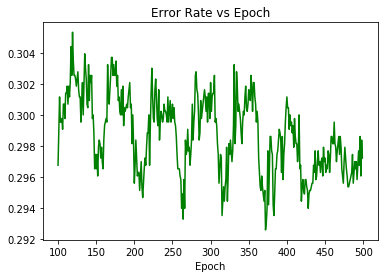

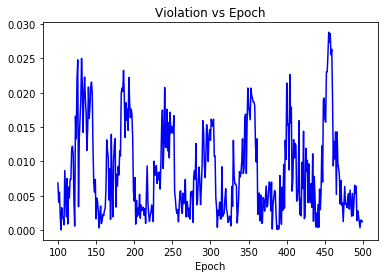

In [10]:
plt.title("Error Rate vs Epoch")
plt.plot(range(100, len(results[0]["all_errors"])), results[0]["all_errors"][100:], color="green")
plt.xlabel("Epoch")
plt.show()
plt.title("Violation vs Epoch")
plt.plot(range(100, len(results[0]["all_violations"])), results[0]["all_violations"][100:], color="blue")
plt.xlabel("Epoch")
plt.show()

### Using stochastic solution.

This motivates the use of stochastic classifiers, which was proposed in [[CoJiSr19]](https://arxiv.org/abs/1804.06500). It was shown that the average iterate has guarantees. 

In [11]:
print("Results for Average Iterate.")
print("Train Error", results[0]["t_stochastic_error_rate"])
print("Train Violation", results[0]["t_stochastic_max_constraint_violation"])

Results for Average Iterate.
Train Error 0.3005370370370371
Train Violation 0.0021946623392345966


### Shrinking the stochastic solution.

The average of all the iterates may be computationally intensive (i.e. requires storing and processing the iterates at each epoch, and the number of iterates may become arbitrarily large). Moreover, the average iterate can have consituents that are suboptimal (especially the early iterates). [[CoJiSr19]](https://arxiv.org/abs/1804.06500) proposed a method to shrink down the uniform mixture of all iterates to one that is a mixture of at most m+1 solutions where m is the number of constraints with guarantees that the new solution will be at least as good as the original solution. This can be done using the find_best_candidate_distribution function. We see an improvement in terms of both fairness and accuracy.

In [12]:
print("Results after Shrinking")
print("Train Error", results[0]["m_stochastic_error_rate"])
print("Train Violation", results[0]["m_stochastic_max_constraint_violation"])

Results after Shrinking
Train Error 0.29370749834992005
Train Violation 5.854691731421724e-18
